In [20]:
import time
from pennylane import numpy as np
import torch
import matplotlib.pyplot as plt
import pennylane as qml


In [21]:
def prepare_molecule(bond_dist):
    """
    Function to initialize the molecule and return the hamiltonian and qubits.
    """
    symbols = ["H", "H"]
    geometry = np.array([[0., 0., -bond_dist/2], [0., 0., bond_dist/2]])  # Coordinates in Bohr
    molecule = qml.qchem.Molecule(symbols, geometry)
    hamiltonian, qubits = qml.qchem.molecular_hamiltonian(molecule)
    
    return hamiltonian, qubits

def advanced_ansatz(params):
    """
    Function to define the advanced quantum circuit ansatz using single excitations.
    """
    hf_state = np.array([1, 1, 0, 0])  # Hartree-Fock state
    # Prepare the Hartree-Fock state
    qml.BasisState(hf_state, wires=[0, 1, 2, 3])
    # Define single excitations
    qml.SingleExcitation(params[0], wires=[0, 2])
    qml.SingleExcitation(params[1], wires=[1, 3])
    qml.SingleExcitation(params[2], wires=[0, 3])
    qml.SingleExcitation(params[3], wires=[1, 2])

def plot_convergence(costs):
    """
    Function to plot the energy convergence during optimization.
    """
    plt.plot(range(len(costs)), costs, '-o', label="Energy", markersize=3)
    plt.xlabel('Iteration')
    plt.ylabel('Energy (Hartree)')
    plt.title('Energy Convergence with UCCS-like Ansatz for H2')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def create_qnode_torch(hamiltonian, qubits):
    """
    Function to create a QNode that computes the expectation value of the Hamiltonian.
    """
    dev = qml.device('default.qubit', wires=qubits)    

    @qml.qnode(dev,interface='torch')
    def circuit(params):
        # Initialize to Hartree-Fock state (|1100⟩ for 4 qubits, 2 electrons in first two orbitals)
        qml.BasisState(np.array([1, 1, 0, 0]), wires=[0, 1, 2, 3])
        
        # Apply variational rotations to each qubit
        for i in range(4):
            qml.Rot(params[i, 0], params[i, 1], params[i, 2], wires=i)
        
        # Apply entangling gates for correlation
        qml.CNOT(wires=[2, 3])
        qml.CNOT(wires=[2, 0])
        qml.CNOT(wires=[3, 1])
        
        # Return the expectation value
        return qml.expval(hamiltonian)
    return circuit

def create_qnode_advanced_torch(hamiltonian, qubits):
    """
    Function to create a QNode that computes the expectation value of the Hamiltonian.
    """
    dev = qml.device('default.qubit', wires=qubits)    

    @qml.qnode(dev,interface='torch')
    def circuit(params):
        advanced_ansatz(params)
        return qml.expval(hamiltonian)
    
    return circuit

def torch_optimize(qnode, init_params, step_num, optimizer_class, lr, patience=50, verbose=False):
    """
    Function to perform optimization using torch and the given optimizer, with added patience for convergence.
    """
    params = torch.from_numpy(np.copy(init_params)).float()
    params.requires_grad = True

    optimizer = optimizer_class(params=[params], lr=lr)  # Initialize optimizer with the given parameters
    costs = []
    times = []
    prev_cost = float("-inf")
    conv_tol = 1e-06
    patience_counter = 0

    for i in range(step_num):
        # Define the closure for L-BFGS optimizer
        start_time = time.time()
        
        def closure():
            optimizer.zero_grad()
            cost = qnode(params)
            if cost.requires_grad:
                cost.backward()
            return cost.detach().numpy()

        # Perform optimization step
        cost = optimizer.step(closure)
        costs.append(cost)
        
        # Check for convergence with patience
        conv = np.abs(cost - prev_cost)
        if conv <= conv_tol:
            patience_counter += 1
            if patience_counter >= patience:
                break
        else:
            patience_counter = 0  # Reset patience if cost changes significantly
        
        prev_cost = cost
        times.append(time.time() - start_time)
        
        if verbose and (i + 1) % 100 == 0:
            print(f"Cost after step {i + 1}: {costs[-1]}")
    
    return costs, times, i


def optimizer_run_pytorch(opt, step_num, bond_dist, lr, verbose=True):
    """
    Main function that prepares the molecule, initializes the QNode,
    runs optimization, and plots the results.
    """
    # Prepare the molecule and hamiltonian
    hamiltonian, qubits = prepare_molecule(bond_dist)
    
    # Create QNode
    qnode = create_qnode_torch(hamiltonian, qubits)

    # Initialize parameters and run optimization
    init_params = np.random.normal(0, np.pi, (4, 3), requires_grad=True)
    costs, times, steps = torch_optimize(qnode, init_params, step_num, opt, lr, verbose=verbose)
    if (verbose):
        # Plot the energy convergence
        plot_convergence(costs)
    
    return costs, times, steps



In [23]:
def create_qnode(hamiltonian, qubits):
    """
    Function to create a QNode that computes the expectation value of the Hamiltonian.
    """
    dev = qml.device('default.qubit', wires=qubits)    
    @qml.qnode(dev)  # Use default NumPy interface
    def circuit(params):
        # Initialize to Hartree-Fock state (|1100⟩ for 4 qubits, 2 electrons in first two orbitals)
        qml.BasisState(np.array([1, 1, 0, 0]), wires=[0, 1, 2, 3])
        
        # Apply variational rotations to each qubit
        for i in range(4):
            qml.Rot(params[i, 0], params[i, 1], params[i, 2], wires=i)
        
        # Apply entangling gates for correlation
        qml.CNOT(wires=[2, 3])
        qml.CNOT(wires=[2, 0])
        qml.CNOT(wires=[3, 1])
        
        # Return the expectation value
        return qml.expval(hamiltonian)
    return circuit

def pennylane_optimize(qnode, init_params, step_num, opt_class, stepsize, patience=50, verbose=False):
    """
    Function to perform optimization using PennyLane's optimizers with a patience mechanism for convergence.
    """
    params = np.copy(init_params)  # Use NumPy array for parameters
    opt = opt_class(stepsize=stepsize)  # Instantiate the PennyLane optimizer
    costs = []
    times = []
    prev_cost = float('inf')
    conv_tol = 1e-6
    patience_counter = 0

    for i in range(step_num):
        start_time = time.time()
        new_params, cost = opt.step_and_cost(qnode, params)  # Perform one optimization step
        params = new_params
        costs.append(cost)
        times.append(time.time() - start_time)
        
        # Check for convergence
        conv = np.abs(cost - prev_cost)
        if conv <= conv_tol:
            patience_counter += 1
            if patience_counter >= patience:
                if verbose:
                    print(f"Converged after {i + 1} steps with cost: {cost}")
                break
        else:
            patience_counter = 0
        prev_cost = cost
        
        if verbose and (i + 1) % 100 == 0:
            print(f"Cost after step {i + 1}: {cost}")
    
    return costs, times, i


def optimizer_run(opt_class, step_num, bond_dist, stepsize, verbose=True):
    """
    Main function that prepares the molecule, initializes the QNode,
    runs optimization, and plots the results.
    """
    # Prepare the molecule and hamiltonian
    hamiltonian, qubits = prepare_molecule(bond_dist)
    
    # Create QNode
    qnode = create_qnode(hamiltonian, qubits)

    # Initialize parameters and run optimization
    init_params = np.random.normal(0, np.pi, (4, 3), requires_grad=True) # Random initial parameters
    costs, times, steps = pennylane_optimize(qnode, init_params, step_num, opt_class, stepsize, patience=50, verbose=verbose)
    
    if verbose:
        # Plot the energy convergence
        plot_convergence(costs)
    
    return costs, times, steps


Cost after step 100: -1.1189182851499768
Cost after step 200: -1.1292186196442
Cost after step 300: -1.1356478586725924
Cost after step 400: -1.1361618109467724
Converged after 444 steps with cost: -1.1361820738851396


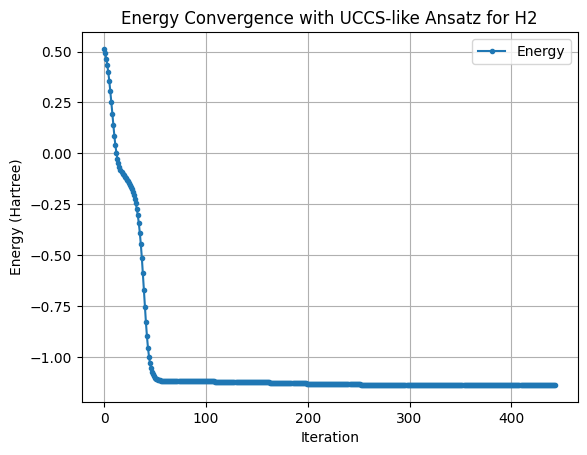

In [24]:
costs, times, steps = optimizer_run(qml.GradientDescentOptimizer, step_num=10000, bond_dist = 0.66140414*2, stepsize=0.4, verbose=True)

Cost after step 100: -1.1126223602726697
Cost after step 200: -1.121321733904328
Cost after step 300: -1.124098918583095
Cost after step 400: -1.1274916210719026
Cost after step 500: -1.1307181844870764
Cost after step 600: -1.1331182366625545
Cost after step 700: -1.1345940965958796
Cost after step 800: -1.1353972896406517
Cost after step 900: -1.1358054960017316
Cost after step 1000: -1.1360055316832414
Cost after step 1100: -1.1361018008252621


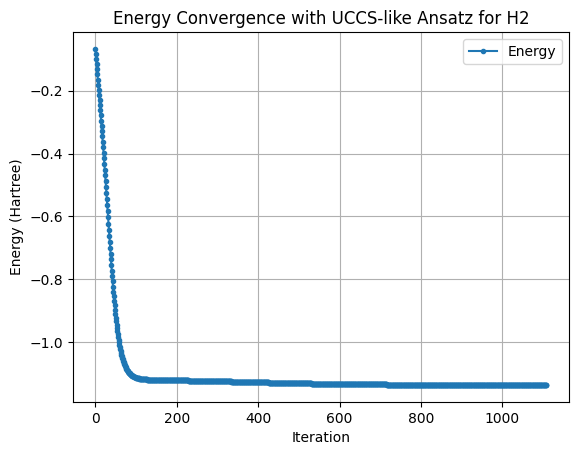

-1.1361073956522163 1108


In [29]:
costs, times, steps = optimizer_run_pytorch(torch.optim.SGD, step_num=10000, bond_dist = 1.32280828, lr = 1e-1,  verbose=True)
print(costs[-1],steps)

In [42]:
def energy_vs_bondLength(optimzer):
    # Define a range of bond lengths (in Bohr, 1 Bohr = 0.529 Å)
    bond_lengths = np.linspace(0.5, 3.0, 30)  # From 0.5 to 3.0 Bohr

    # Lists to store results
    final_energies = []
    convergence_iterations = []

    # Loop over bond lengths
    for bond_length in bond_lengths:
        
        costs, times, steps = optimizer_run(optimzer, step_num = 10000, bond_dist = bond_length, stepsize= 0.4,  verbose=False)
        # Store results
        final_energies.append(costs[-1])
        convergence_iterations.append(steps + 1)
        print(f"Bond length: {bond_length:.2f} Bohr, Energy: {costs[-1]:.6f} Ha, Iterations: {steps + 1}")

    # Create two subplots
    plt.figure(figsize=(12, 5))

    # Plot 1: Energy vs. Bond Length (Potential Energy Curve)
    plt.subplot(1, 2, 1)
    plt.plot(bond_lengths, final_energies, 'o-', label="Ground State Energy")
    plt.xlabel('Bond Length (Bohr)')
    plt.ylabel('Energy (Hartree)')
    plt.title('Potential Energy Curve of H2')
    plt.legend()
    plt.grid(True)

Bond length: 0.50 Bohr, Energy: 1.115401 Ha, Iterations: 153
Bond length: 0.59 Bohr, Energy: 0.709180 Ha, Iterations: 210
Bond length: 0.67 Bohr, Energy: -0.806474 Ha, Iterations: 809
Bond length: 0.76 Bohr, Energy: -0.917046 Ha, Iterations: 364
Bond length: 0.84 Bohr, Energy: 0.098215 Ha, Iterations: 189
Bond length: 0.93 Bohr, Energy: -1.048198 Ha, Iterations: 234
Bond length: 1.02 Bohr, Energy: -1.085252 Ha, Iterations: 264
Bond length: 1.10 Bohr, Energy: -1.109915 Ha, Iterations: 327
Bond length: 1.19 Bohr, Energy: -1.125352 Ha, Iterations: 194
Bond length: 1.28 Bohr, Energy: -0.442152 Ha, Iterations: 154
Bond length: 1.36 Bohr, Energy: -0.506517 Ha, Iterations: 123
Bond length: 1.45 Bohr, Energy: -1.136508 Ha, Iterations: 184
Bond length: 1.53 Bohr, Energy: -1.132976 Ha, Iterations: 224
Bond length: 1.62 Bohr, Energy: -0.649820 Ha, Iterations: 132
Bond length: 1.71 Bohr, Energy: -0.685209 Ha, Iterations: 162
Bond length: 1.79 Bohr, Energy: -1.111558 Ha, Iterations: 224
Bond length

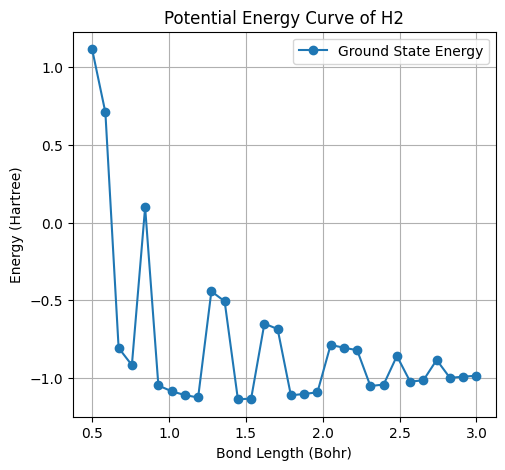

In [43]:
energy_vs_bondLength(qml.GradientDescentOptimizer)